In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import optuna
from joblib import dump, load
import shap


In [2]:
## Functions 
def evaluate_linear_baseline(data, base_features, max_degree=2, combo_size=5):
    results = []

    # Crear bloques temporales
    all_weeks = sorted(data['week'].dropna().unique())
    week_blocks = [all_weeks[i:i+5] for i in range(0, len(all_weeks), 5)]

    # Probar combinaciones de variables
    for feature_combo in combinations(base_features, combo_size):
        feature_combo = list(feature_combo)

        for degree in range(1, max_degree+1):
            rmses_train, rmses_test, corrs_train, corrs_test = [], [], [], []

            for week_block in week_blocks:
                fold_test = data[data['week'].isin(week_block)].copy()
                fold_train = data[~data['week'].isin(week_block)].copy()

                if fold_test.empty or fold_train.empty:
                    continue

                try:
                    # Subset y eliminar NaNs
                    train_subset = fold_train[feature_combo + ['Tmax']].dropna()
                    test_subset = fold_test[feature_combo + ['Tmax']].dropna()

                    if train_subset.empty or test_subset.empty:
                        continue

                    # Separar X e y
                    X_train_raw = train_subset[feature_combo]
                    y_train = train_subset['Tmax']

                    X_test_raw = test_subset[feature_combo]
                    y_test = test_subset['Tmax']

                    # Transformaciones polinómicas
                    poly = PolynomialFeatures(degree=degree, include_bias=False)
                    X_train = poly.fit_transform(X_train_raw)
                    X_test = poly.transform(X_test_raw)
                    
                    

                    # Entrenar modelo
                    model_linear = LinearRegression()
                    
                    model_linear.fit(X_train, y_train)

                    # Predicciones
                    preds_train = model_linear.predict(X_train)
                    preds_test = model_linear.predict(X_test)

                    # RMSE
                    rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
                    rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))

                    # Correlaciones protegidas
                    valid_train = ~np.isnan(y_train) & ~np.isnan(preds_train)
                    valid_test = ~np.isnan(y_test) & ~np.isnan(preds_test)

                    corr_train = pearsonr(y_train[valid_train], preds_train[valid_train])[0] if valid_train.sum() > 1 else np.nan
                    corr_test = pearsonr(y_test[valid_test], preds_test[valid_test])[0] if valid_test.sum() > 1 else np.nan

                    # Guardar métricas
                    rmses_train.append(rmse_train)
                    rmses_test.append(rmse_test)
                    corrs_train.append(corr_train)
                    corrs_test.append(corr_test)

                except Exception as e:
                    # Salta bloque si algo falla (opcional)
                    print(f"[WARN] Falló combo {feature_combo} con grado {degree}: {e}")
                    continue

            # Guardar resumen del fold
            results.append({
                'features': feature_combo,
                'degree': degree,
                'rmse_train': np.nanmean(rmses_train),
                'rmse_test': np.nanmean(rmses_test),
                'corr_train': np.nanmean(corrs_train),
                'corr_test': np.nanmean(corrs_test)
            })

    return pd.DataFrame(results)



def evaluate_model(trial):
    import warnings
    warnings.filterwarnings("ignore")
    from scipy.stats import pearsonr

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 70, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "max_delta_step": trial.suggest_int("max_delta_step", 3, 6),
        "gamma": trial.suggest_float("gamma", 2, 20),
        "min_child_weight": trial.suggest_int("min_child_weight", 5, 40),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.001, 10, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.001, 10, log=True),
        "random_state": 50,
        "n_jobs": -1
    }

    rmses_test = []
    rmses_train = []
    cor_test = []
    cor_train = []

    # Crear bloques temporales de 5 semanas
    all_weeks = sorted(df['week'].dropna().unique())
    week_blocks = [all_weeks[i:i+5] for i in range(0, len(all_weeks), 5)]

    for week_block in week_blocks:
        # Usar TODAS las estaciones en cada fold
        fold_test = df[df['week'].isin(week_block)].copy()
        fold_train = df[~df['week'].isin(week_block)].copy()

        if fold_test.empty or fold_train.empty:
            continue

        model = XGBRegressor(**params)
        model.fit(
            fold_train[features],
            fold_train['Tmax'],
            sample_weight=fold_train['sample_weight']
        )
        
        # Predicciones
        preds_test = model.predict(fold_test[features])
        preds_train = model.predict(fold_train[features])

        # RMSE
        rmse_test = np.sqrt(mean_squared_error(fold_test['Tmax'], preds_test))
        rmse_train = np.sqrt(mean_squared_error(fold_train['Tmax'], preds_train))

        # Correlaciones protegidas
        valid_train = ~fold_train['Tmax'].isna() & ~np.isnan(preds_train)
        valid_test = ~fold_test['Tmax'].isna() & ~np.isnan(preds_test)

        if valid_train.sum() > 1:
            corr_train = pearsonr(fold_train.loc[valid_train, 'Tmax'], preds_train[valid_train])[0]
        else:
            corr_train = np.nan

        if valid_test.sum() > 1:
            corr_test = pearsonr(fold_test.loc[valid_test, 'Tmax'], preds_test[valid_test])[0]
        else:
            corr_test = np.nan

        # Guardar métricas
        rmses_train.append(rmse_train)
        rmses_test.append(rmse_test)
        cor_train.append(corr_train)
        cor_test.append(corr_test)

    print(f"RMSE Train: {np.nanmean(rmses_train):.3f} | Pearson Train: {np.nanmean(cor_train):.3f}")
    print(f"RMSE Test:  {np.nanmean(rmses_test):.3f} | Pearson Test:  {np.nanmean(cor_test):.3f}")

    return np.nanmean(rmses_test) + 0.5 * abs(np.nanmean(rmses_test) - np.nanmean(rmses_train))



In [3]:
df = pd.read_parquet("D:/OneDrive - CGIAR/Desktop/downscaling/data/features/tmax_features.parquet")
df.shape

(1420, 17)

## Regresión Lineal 

In [4]:
def make_weights(y):
    y_centered = y - y.mean()
    return 1 + (y_centered / y_centered.std())**2

df['sample_weight'] = make_weights(df['Tmax'])

# Crear week_sin y week_cos
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)


In [5]:
# Seleccionar subconjunto de variables relevantes
base_vars = ['tmax_saga', 'tmin_saga', 'slope', 'aspect', 'tpi', 'cumbre', 'valle', 'rugosity', 'dem', 'ndvi']
# Evaluar
resultados_baseline = evaluate_linear_baseline(df, base_vars, max_degree=2, combo_size=5)

# Ver los mejores resultados ordenados
resultados_baseline.sort_values(by='rmse_test').head(10)

,features,degree,rmse_train,rmse_test,corr_train,corr_test
65,"[tmax_saga, tmin_saga, aspect, valle, ndvi]",2,0.998512,1.006275,0.909635,0.906512
59,"[tmax_saga, tmin_saga, aspect, cumbre, ndvi]",2,0.997332,1.006488,0.909860,0.906510
11,"[tmax_saga, tmin_saga, slope, aspect, ndvi]",2,0.997797,1.007080,0.909771,0.906452
51,"[tmax_saga, tmin_saga, aspect, tpi, ndvi]",2,0.997711,1.007271,0.909788,0.906406
69,"[tmax_saga, tmin_saga, aspect, rugosity, ndvi]",2,0.997999,1.007589,0.909733,0.906371
71,"[tmax_saga, tmin_saga, aspect, dem, ndvi]",2,0.998344,1.008004,0.909667,0.906307
35,"[tmax_saga, tmin_saga, slope, valle, ndvi]",2,1.002001,1.011728,0.908972,0.905599
79,"[tmax_saga, tmin_saga, tpi, cumbre, ndvi]",2,1.001964,1.011743,0.908978,0.905845
107,"[tmax_saga, tmin_saga, valle, rugosity, ndvi]",2,1.002714,1.012660,0.908836,0.905464
109,"[tmax_saga, tmin_saga, valle, dem, ndvi]",2,1.003288,1.013340,0.908726,0.905378


### Ajuste con el mejor modelo lineal

In [6]:
# Mejores features y grado encontrado
mejores_vars = ['tmax_saga', 'tmin_saga', 'aspect', 'valle', 'ndvi']
grado = 2

# Filtrar datos y quitar NaNs
df_modelo = df[mejores_vars + ['Tmax']].dropna()

X_raw = df_modelo[mejores_vars]
y_true = df_modelo['Tmax']

# Transformación polinómica
poly = PolynomialFeatures(degree=grado, include_bias=False)
X_poly = poly.fit_transform(X_raw)

# Ajustar modelo
modelo_final = LinearRegression()
modelo_final.fit(X_poly, y_true)

# Predecir sobre todos los datos
y_pred = modelo_final.predict(X_poly)


In [7]:
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
pearson_corr = pearsonr(y_true, y_pred)[0]

print("RMSE:",rmse)
print("Correlación Pearson:",pearson_corr)

RMSE: 0.9995584928478745
Correlación Pearson: 0.9094880698167459


C:\Users\dagudelo\AppData\Local\Temp\ipykernel_45080\761979180.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


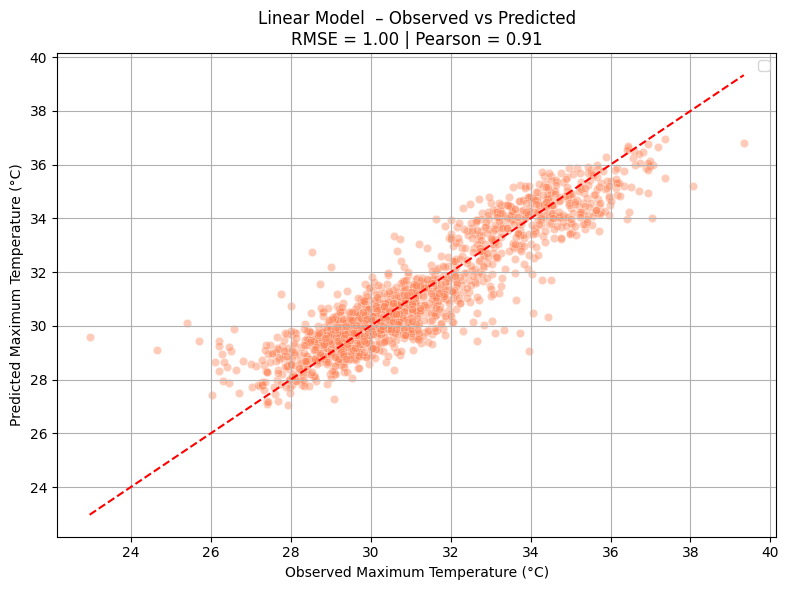

In [9]:
# Crear DataFrame para graficar
tmax_resul_linear = pd.DataFrame({
    'Tmax': y_true,
    'Tmax_pred': y_pred
})

# Graficar
plt.figure(figsize=(8,6))
sns.scatterplot(x='Tmax', y='Tmax_pred', data=tmax_resul_linear, alpha=0.4, color="#FF7F50")
plt.plot([tmax_resul_linear['Tmax'].min(), tmax_resul_linear['Tmax'].max()],
         [tmax_resul_linear['Tmax'].min(), tmax_resul_linear['Tmax'].max()],
         'r--', label='')

plt.xlabel("Observed Maximum Temperature (°C)")
plt.ylabel("Predicted Maximum Temperature (°C)")
plt.title(f"Linear Model  – Observed vs Predicted\nRMSE = {rmse:.2f} | Pearson = {pearson_corr:.2f}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Xgboost 

In [10]:
df.columns

Index(['Estacion', 'year', 'week', 'Tmax', 'Latitud', 'Longitud', 'epi_week',
       'tmax_saga', 'tmin_saga', 'slope', 'aspect', 'tpi', 'cumbre', 'valle',
       'rugosity', 'dem', 'ndvi', 'sample_weight', 'week_sin', 'week_cos'],
      dtype='object')

In [12]:
# Variables predictoras
exclude = ['Tmax', 'Estacion', 'year', 'sample_weight','week', 'epi_week', 'Latitud', 'Longitud','rugosity',"cumbre", "week_cos",'dem','tpi']
features = [c for c in df.columns if c not in exclude]
print(features)
# Lista de estaciones
stations = df['Estacion'].unique()

['tmax_saga', 'tmin_saga', 'slope', 'aspect', 'valle', 'ndvi', 'week_sin']


In [28]:
study = optuna.create_study(direction="minimize")
study.optimize(evaluate_model, n_trials=100)

[I 2025-07-07 15:14:36,930] A new study created in memory with name: no-name-dbb5717b-c59b-464c-b41e-7c7da72d5127
[I 2025-07-07 15:14:39,191] Trial 0 finished with value: 1.270265323207786 and parameters: {'n_estimators': 254, 'max_depth': 8, 'learning_rate': 0.0696964291776921, 'subsample': 0.6287360612139256, 'colsample_bytree': 0.9385387978425725, 'max_delta_step': 5, 'gamma': 8.108017149823201, 'min_child_weight': 22, 'reg_alpha': 0.29534975588563545, 'reg_lambda': 0.012675852008121567}. Best is trial 0 with value: 1.270265323207786.


RMSE Train: 0.747 | Pearson Train: 0.952
RMSE Test:  1.096 | Pearson Test:  0.894


[I 2025-07-07 15:14:44,105] Trial 1 finished with value: 1.2730780518988625 and parameters: {'n_estimators': 843, 'max_depth': 4, 'learning_rate': 0.045856539544980854, 'subsample': 0.6838632782533948, 'colsample_bytree': 0.7520248007613028, 'max_delta_step': 4, 'gamma': 7.2029934746582125, 'min_child_weight': 18, 'reg_alpha': 0.043258273950495765, 'reg_lambda': 0.024597427111554937}. Best is trial 0 with value: 1.270265323207786.


RMSE Train: 0.757 | Pearson Train: 0.950
RMSE Test:  1.101 | Pearson Test:  0.893


[I 2025-07-07 15:14:50,989] Trial 2 finished with value: 1.3209990021209779 and parameters: {'n_estimators': 656, 'max_depth': 7, 'learning_rate': 0.16455713923610218, 'subsample': 0.6310418595289419, 'colsample_bytree': 0.8669554196352184, 'max_delta_step': 6, 'gamma': 9.9495860673625, 'min_child_weight': 19, 'reg_alpha': 0.07155798463593313, 'reg_lambda': 0.0176898558571795}. Best is trial 0 with value: 1.270265323207786.


RMSE Train: 0.706 | Pearson Train: 0.957
RMSE Test:  1.116 | Pearson Test:  0.889


[I 2025-07-07 15:14:52,496] Trial 3 finished with value: 1.2175011148220665 and parameters: {'n_estimators': 139, 'max_depth': 7, 'learning_rate': 0.14655673593363605, 'subsample': 0.9139799650497865, 'colsample_bytree': 0.9723709358671104, 'max_delta_step': 4, 'gamma': 16.50978643222021, 'min_child_weight': 30, 'reg_alpha': 0.0042440355292946135, 'reg_lambda': 1.0220522876371494}. Best is trial 3 with value: 1.2175011148220665.


RMSE Train: 0.888 | Pearson Train: 0.932
RMSE Test:  1.108 | Pearson Test:  0.893


[I 2025-07-07 15:14:55,001] Trial 4 finished with value: 1.2039086755450574 and parameters: {'n_estimators': 370, 'max_depth': 3, 'learning_rate': 0.06570575851036121, 'subsample': 0.8516357490489974, 'colsample_bytree': 0.830827140940942, 'max_delta_step': 5, 'gamma': 4.814710168035988, 'min_child_weight': 32, 'reg_alpha': 1.775614930117819, 'reg_lambda': 0.04111919311157792}. Best is trial 4 with value: 1.2039086755450574.


RMSE Train: 0.866 | Pearson Train: 0.936
RMSE Test:  1.091 | Pearson Test:  0.896


[I 2025-07-07 15:14:58,733] Trial 5 finished with value: 1.259648888996797 and parameters: {'n_estimators': 408, 'max_depth': 7, 'learning_rate': 0.03665114969140093, 'subsample': 0.865957230823325, 'colsample_bytree': 0.8847769786592601, 'max_delta_step': 4, 'gamma': 6.99340762175044, 'min_child_weight': 26, 'reg_alpha': 1.0890079023373147, 'reg_lambda': 0.0020151335205461397}. Best is trial 4 with value: 1.2039086755450574.


RMSE Train: 0.766 | Pearson Train: 0.949
RMSE Test:  1.095 | Pearson Test:  0.894


[I 2025-07-07 15:15:07,786] Trial 6 finished with value: 1.3993131020512017 and parameters: {'n_estimators': 659, 'max_depth': 9, 'learning_rate': 0.182489349667415, 'subsample': 0.8008509093404912, 'colsample_bytree': 0.9009809885454381, 'max_delta_step': 4, 'gamma': 5.538731451321011, 'min_child_weight': 35, 'reg_alpha': 0.09610567584197618, 'reg_lambda': 0.18823950464161676}. Best is trial 4 with value: 1.2039086755450574.


RMSE Train: 0.625 | Pearson Train: 0.966
RMSE Test:  1.141 | Pearson Test:  0.885


[I 2025-07-07 15:15:19,016] Trial 7 finished with value: 1.2090975537373685 and parameters: {'n_estimators': 871, 'max_depth': 8, 'learning_rate': 0.0644518609077234, 'subsample': 0.9555730910272913, 'colsample_bytree': 0.8953495930182086, 'max_delta_step': 3, 'gamma': 17.21060259751321, 'min_child_weight': 19, 'reg_alpha': 0.1461019406814419, 'reg_lambda': 1.8425641992402522}. Best is trial 4 with value: 1.2039086755450574.


RMSE Train: 0.852 | Pearson Train: 0.937
RMSE Test:  1.090 | Pearson Test:  0.896


[I 2025-07-07 15:15:19,801] Trial 8 finished with value: 17.15005134948493 and parameters: {'n_estimators': 153, 'max_depth': 5, 'learning_rate': 0.01796520359826751, 'subsample': 0.6411788063390721, 'colsample_bytree': 0.9547241240910564, 'max_delta_step': 5, 'gamma': 19.40850955802966, 'min_child_weight': 37, 'reg_alpha': 0.9268143334787378, 'reg_lambda': 0.0071813064802430425}. Best is trial 4 with value: 1.2039086755450574.


RMSE Train: 17.141 | Pearson Train: nan
RMSE Test:  17.147 | Pearson Test:  nan


[I 2025-07-07 15:15:20,357] Trial 9 finished with value: 6.268730980798081 and parameters: {'n_estimators': 87, 'max_depth': 10, 'learning_rate': 0.057415334056414837, 'subsample': 0.9027455317087458, 'colsample_bytree': 0.7898122935158276, 'max_delta_step': 5, 'gamma': 17.823766195531316, 'min_child_weight': 36, 'reg_alpha': 0.501131653698283, 'reg_lambda': 0.003973294897098529}. Best is trial 4 with value: 1.2039086755450574.


RMSE Train: 6.268 | Pearson Train: 0.574
RMSE Test:  6.268 | Pearson Test:  0.507


[I 2025-07-07 15:15:22,978] Trial 10 finished with value: 1.245631129380694 and parameters: {'n_estimators': 404, 'max_depth': 3, 'learning_rate': 0.10996511023311119, 'subsample': 0.7535328297104383, 'colsample_bytree': 0.6376641500916479, 'max_delta_step': 6, 'gamma': 2.3528069268543734, 'min_child_weight': 12, 'reg_alpha': 9.509383447749244, 'reg_lambda': 0.1583155297381617}. Best is trial 4 with value: 1.2039086755450574.


RMSE Train: 0.789 | Pearson Train: 0.946
RMSE Test:  1.093 | Pearson Test:  0.896


[I 2025-07-07 15:15:31,425] Trial 11 finished with value: 1.1797555939596882 and parameters: {'n_estimators': 965, 'max_depth': 5, 'learning_rate': 0.09293602410521962, 'subsample': 0.9903239830028201, 'colsample_bytree': 0.8265404165830185, 'max_delta_step': 3, 'gamma': 13.858499714989286, 'min_child_weight': 11, 'reg_alpha': 7.136369420973614, 'reg_lambda': 9.57605580804789}. Best is trial 11 with value: 1.1797555939596882.


RMSE Train: 0.905 | Pearson Train: 0.930
RMSE Test:  1.088 | Pearson Test:  0.897


[I 2025-07-07 15:15:40,457] Trial 12 finished with value: 1.1648885758304102 and parameters: {'n_estimators': 997, 'max_depth': 5, 'learning_rate': 0.10320765023990836, 'subsample': 0.9942331698548166, 'colsample_bytree': 0.7243098486789243, 'max_delta_step': 3, 'gamma': 13.456567745656454, 'min_child_weight': 9, 'reg_alpha': 7.831668499667631, 'reg_lambda': 7.730942022059844}. Best is trial 12 with value: 1.1648885758304102.


RMSE Train: 0.900 | Pearson Train: 0.930
RMSE Test:  1.077 | Pearson Test:  0.899


[I 2025-07-07 15:15:49,214] Trial 13 finished with value: 1.1678726322605666 and parameters: {'n_estimators': 966, 'max_depth': 5, 'learning_rate': 0.10701752229412674, 'subsample': 0.9955213973060361, 'colsample_bytree': 0.7168173607620872, 'max_delta_step': 3, 'gamma': 13.371527501032546, 'min_child_weight': 5, 'reg_alpha': 9.052648570802372, 'reg_lambda': 8.25237069478264}. Best is trial 12 with value: 1.1648885758304102.


RMSE Train: 0.906 | Pearson Train: 0.929
RMSE Test:  1.081 | Pearson Test:  0.899


[I 2025-07-07 15:15:57,838] Trial 14 finished with value: 1.1761083396020031 and parameters: {'n_estimators': 994, 'max_depth': 5, 'learning_rate': 0.12397802970524625, 'subsample': 0.9898539754288376, 'colsample_bytree': 0.7050621272588269, 'max_delta_step': 3, 'gamma': 13.069399826605514, 'min_child_weight': 5, 'reg_alpha': 3.1433103933920985, 'reg_lambda': 8.310741217507154}. Best is trial 12 with value: 1.1648885758304102.


RMSE Train: 0.879 | Pearson Train: 0.934
RMSE Test:  1.077 | Pearson Test:  0.899


[I 2025-07-07 15:16:05,291] Trial 15 finished with value: 1.2272153537703745 and parameters: {'n_estimators': 766, 'max_depth': 6, 'learning_rate': 0.134089751190189, 'subsample': 0.9361449642690391, 'colsample_bytree': 0.6724012774766994, 'max_delta_step': 3, 'gamma': 12.838414233855573, 'min_child_weight': 5, 'reg_alpha': 0.005881894880269265, 'reg_lambda': 2.046100032845493}. Best is trial 12 with value: 1.1648885758304102.


RMSE Train: 0.803 | Pearson Train: 0.944
RMSE Test:  1.086 | Pearson Test:  0.897


[I 2025-07-07 15:16:10,155] Trial 16 finished with value: 1.2129894034143525 and parameters: {'n_estimators': 673, 'max_depth': 4, 'learning_rate': 0.09299082210786606, 'subsample': 0.8014528454650496, 'colsample_bytree': 0.7289593431256806, 'max_delta_step': 3, 'gamma': 14.857089678652788, 'min_child_weight': 10, 'reg_alpha': 0.021759528882577695, 'reg_lambda': 0.5972490752784031}. Best is trial 12 with value: 1.1648885758304102.


RMSE Train: 0.846 | Pearson Train: 0.938
RMSE Test:  1.091 | Pearson Test:  0.896


[I 2025-07-07 15:16:18,877] Trial 17 finished with value: 1.2025200967215224 and parameters: {'n_estimators': 891, 'max_depth': 6, 'learning_rate': 0.1000274593659005, 'subsample': 0.999319867057382, 'colsample_bytree': 0.6099336058000682, 'max_delta_step': 3, 'gamma': 10.91597936865592, 'min_child_weight': 15, 'reg_alpha': 3.3852160346642615, 'reg_lambda': 3.793169102877052}. Best is trial 12 with value: 1.1648885758304102.


RMSE Train: 0.848 | Pearson Train: 0.938
RMSE Test:  1.084 | Pearson Test:  0.897


[I 2025-07-07 15:16:25,145] Trial 18 finished with value: 1.2039261320111394 and parameters: {'n_estimators': 769, 'max_depth': 4, 'learning_rate': 0.19718060244450325, 'subsample': 0.8815005967393563, 'colsample_bytree': 0.7738803052521571, 'max_delta_step': 4, 'gamma': 15.245548596336352, 'min_child_weight': 8, 'reg_alpha': 9.830707478621289, 'reg_lambda': 0.5753588949526697}. Best is trial 12 with value: 1.1648885758304102.


RMSE Train: 0.868 | Pearson Train: 0.935
RMSE Test:  1.092 | Pearson Test:  0.896


[I 2025-07-07 15:16:29,992] Trial 19 finished with value: 1.260158598925885 and parameters: {'n_estimators': 564, 'max_depth': 6, 'learning_rate': 0.15031448552810306, 'subsample': 0.7375507017547649, 'colsample_bytree': 0.6976327113602294, 'max_delta_step': 3, 'gamma': 11.756963399059702, 'min_child_weight': 15, 'reg_alpha': 0.001029622867620927, 'reg_lambda': 4.964692793777196}. Best is trial 12 with value: 1.1648885758304102.


RMSE Train: 0.792 | Pearson Train: 0.946
RMSE Test:  1.104 | Pearson Test:  0.894


[I 2025-07-07 15:16:38,414] Trial 20 finished with value: 1.2670217831824453 and parameters: {'n_estimators': 988, 'max_depth': 5, 'learning_rate': 0.12133957743819401, 'subsample': 0.9464386763771725, 'colsample_bytree': 0.6581345688391703, 'max_delta_step': 4, 'gamma': 8.756534144204016, 'min_child_weight': 7, 'reg_alpha': 2.5634715513361037, 'reg_lambda': 0.332623565066463}. Best is trial 12 with value: 1.1648885758304102.


RMSE Train: 0.736 | Pearson Train: 0.953
RMSE Test:  1.090 | Pearson Test:  0.895


[I 2025-07-07 15:16:47,054] Trial 21 finished with value: 1.18706550310922 and parameters: {'n_estimators': 995, 'max_depth': 5, 'learning_rate': 0.12149285743304362, 'subsample': 0.9767389536645367, 'colsample_bytree': 0.7039817481951622, 'max_delta_step': 3, 'gamma': 12.85443949081825, 'min_child_weight': 5, 'reg_alpha': 3.9631817367295503, 'reg_lambda': 9.232497507100403}. Best is trial 12 with value: 1.1648885758304102.


RMSE Train: 0.874 | Pearson Train: 0.934
RMSE Test:  1.083 | Pearson Test:  0.898


[I 2025-07-07 15:16:53,891] Trial 22 finished with value: 1.179602756240686 and parameters: {'n_estimators': 907, 'max_depth': 4, 'learning_rate': 0.08669698143065993, 'subsample': 0.9590622509356665, 'colsample_bytree': 0.7264883399676493, 'max_delta_step': 3, 'gamma': 15.311227685239459, 'min_child_weight': 8, 'reg_alpha': 3.970466913989347, 'reg_lambda': 3.6102261269811304}. Best is trial 12 with value: 1.1648885758304102.


RMSE Train: 0.893 | Pearson Train: 0.932
RMSE Test:  1.084 | Pearson Test:  0.897


[I 2025-07-07 15:17:00,848] Trial 23 finished with value: 1.216653396401102 and parameters: {'n_estimators': 766, 'max_depth': 5, 'learning_rate': 0.11986089525161091, 'subsample': 0.9972462621703805, 'colsample_bytree': 0.7542166596758082, 'max_delta_step': 3, 'gamma': 11.465909905039132, 'min_child_weight': 12, 'reg_alpha': 1.4423469822979207, 'reg_lambda': 1.5624760593776466}. Best is trial 12 with value: 1.1648885758304102.


RMSE Train: 0.844 | Pearson Train: 0.939
RMSE Test:  1.092 | Pearson Test:  0.896


[I 2025-07-07 15:17:08,496] Trial 24 finished with value: 1.1987636655948786 and parameters: {'n_estimators': 825, 'max_depth': 6, 'learning_rate': 0.08024986739044303, 'subsample': 0.9262888416069064, 'colsample_bytree': 0.6870459368679094, 'max_delta_step': 3, 'gamma': 13.671169889201673, 'min_child_weight': 5, 'reg_alpha': 0.3934103285656725, 'reg_lambda': 9.955791380190313}. Best is trial 12 with value: 1.1648885758304102.


RMSE Train: 0.861 | Pearson Train: 0.936
RMSE Test:  1.086 | Pearson Test:  0.898


[I 2025-07-07 15:17:14,111] Trial 25 finished with value: 1.2184876565654907 and parameters: {'n_estimators': 943, 'max_depth': 3, 'learning_rate': 0.13617417073906135, 'subsample': 0.8979639432795201, 'colsample_bytree': 0.625342941531067, 'max_delta_step': 4, 'gamma': 10.030431403441819, 'min_child_weight': 15, 'reg_alpha': 5.150659707814421, 'reg_lambda': 2.566906552823108}. Best is trial 12 with value: 1.1648885758304102.


RMSE Train: 0.844 | Pearson Train: 0.939
RMSE Test:  1.094 | Pearson Test:  0.896


[I 2025-07-07 15:17:21,650] Trial 26 finished with value: 1.1843830321666613 and parameters: {'n_estimators': 999, 'max_depth': 4, 'learning_rate': 0.11012536937223004, 'subsample': 0.8374870295177894, 'colsample_bytree': 0.720403258332806, 'max_delta_step': 3, 'gamma': 19.976926019670415, 'min_child_weight': 9, 'reg_alpha': 0.5975524882064962, 'reg_lambda': 0.06972346182467808}. Best is trial 12 with value: 1.1648885758304102.


RMSE Train: 0.877 | Pearson Train: 0.934
RMSE Test:  1.082 | Pearson Test:  0.898


[I 2025-07-07 15:17:28,577] Trial 27 finished with value: 1.2315298029178783 and parameters: {'n_estimators': 811, 'max_depth': 5, 'learning_rate': 0.16493014912556686, 'subsample': 0.9560149301408385, 'colsample_bytree': 0.65363888833411, 'max_delta_step': 4, 'gamma': 12.449954693417673, 'min_child_weight': 13, 'reg_alpha': 2.4356849067413573, 'reg_lambda': 0.9595653299085365}. Best is trial 12 with value: 1.1648885758304102.


RMSE Train: 0.811 | Pearson Train: 0.943
RMSE Test:  1.091 | Pearson Test:  0.896


[I 2025-07-07 15:17:38,347] Trial 28 finished with value: 1.195189244822142 and parameters: {'n_estimators': 915, 'max_depth': 6, 'learning_rate': 0.07877081023045912, 'subsample': 0.968541016734443, 'colsample_bytree': 0.7715487284798149, 'max_delta_step': 3, 'gamma': 14.275911564342925, 'min_child_weight': 7, 'reg_alpha': 0.2365491992649133, 'reg_lambda': 5.169993731778133}. Best is trial 12 with value: 1.1648885758304102.


RMSE Train: 0.850 | Pearson Train: 0.938
RMSE Test:  1.080 | Pearson Test:  0.898


[I 2025-07-07 15:17:45,118] Trial 29 finished with value: 1.2030555764541642 and parameters: {'n_estimators': 534, 'max_depth': 8, 'learning_rate': 0.1376965192194264, 'subsample': 0.9198111390777373, 'colsample_bytree': 0.8066060216694223, 'max_delta_step': 3, 'gamma': 16.477524456304234, 'min_child_weight': 23, 'reg_alpha': 5.761073768080104, 'reg_lambda': 4.868508284864575}. Best is trial 12 with value: 1.1648885758304102.


RMSE Train: 0.865 | Pearson Train: 0.936
RMSE Test:  1.091 | Pearson Test:  0.895


[I 2025-07-07 15:17:53,896] Trial 30 finished with value: 1.2943486339616288 and parameters: {'n_estimators': 712, 'max_depth': 7, 'learning_rate': 0.10211261488748606, 'subsample': 0.8243575832733285, 'colsample_bytree': 0.7328326888235454, 'max_delta_step': 5, 'gamma': 9.751545385216016, 'min_child_weight': 5, 'reg_alpha': 1.102000434010052, 'reg_lambda': 0.3735515425333466}. Best is trial 12 with value: 1.1648885758304102.


RMSE Train: 0.707 | Pearson Train: 0.957
RMSE Test:  1.099 | Pearson Test:  0.894


[I 2025-07-07 15:18:00,977] Trial 31 finished with value: 1.1802783930690393 and parameters: {'n_estimators': 906, 'max_depth': 4, 'learning_rate': 0.08143791032951837, 'subsample': 0.9646579957751976, 'colsample_bytree': 0.7102131456009989, 'max_delta_step': 3, 'gamma': 15.177448181630277, 'min_child_weight': 9, 'reg_alpha': 4.152063480442168, 'reg_lambda': 4.189612713538391}. Best is trial 12 with value: 1.1648885758304102.


RMSE Train: 0.900 | Pearson Train: 0.930
RMSE Test:  1.087 | Pearson Test:  0.898


[I 2025-07-07 15:18:08,745] Trial 32 finished with value: 1.1824303516259025 and parameters: {'n_estimators': 934, 'max_depth': 4, 'learning_rate': 0.0862324921789478, 'subsample': 0.9713802108044556, 'colsample_bytree': 0.7469574819095728, 'max_delta_step': 3, 'gamma': 15.803531574397118, 'min_child_weight': 7, 'reg_alpha': 2.177310716384302, 'reg_lambda': 2.7064027839644558}. Best is trial 12 with value: 1.1648885758304102.


RMSE Train: 0.893 | Pearson Train: 0.932
RMSE Test:  1.086 | Pearson Test:  0.897


[I 2025-07-07 15:18:15,132] Trial 33 finished with value: 1.1556543591866604 and parameters: {'n_estimators': 854, 'max_depth': 4, 'learning_rate': 0.11272494737911348, 'subsample': 0.9961322233590226, 'colsample_bytree': 0.6875900898456195, 'max_delta_step': 3, 'gamma': 18.344042041218795, 'min_child_weight': 40, 'reg_alpha': 9.897473367285794, 'reg_lambda': 7.107534445320376}. Best is trial 33 with value: 1.1556543591866604.


RMSE Train: 0.972 | Pearson Train: 0.919
RMSE Test:  1.095 | Pearson Test:  0.898


[I 2025-07-07 15:18:22,769] Trial 34 finished with value: 1.185215120853853 and parameters: {'n_estimators': 855, 'max_depth': 5, 'learning_rate': 0.11736120496174328, 'subsample': 0.9935485832670177, 'colsample_bytree': 0.677792927257878, 'max_delta_step': 4, 'gamma': 13.340406149050501, 'min_child_weight': 39, 'reg_alpha': 8.307979842341723, 'reg_lambda': 6.862168191316011}. Best is trial 33 with value: 1.1556543591866604.


RMSE Train: 0.924 | Pearson Train: 0.927
RMSE Test:  1.098 | Pearson Test:  0.897


[I 2025-07-07 15:18:28,298] Trial 35 finished with value: 1.1760320355036755 and parameters: {'n_estimators': 820, 'max_depth': 3, 'learning_rate': 0.15769254579198627, 'subsample': 0.9359054592093713, 'colsample_bytree': 0.6000094173654679, 'max_delta_step': 6, 'gamma': 18.679779003329678, 'min_child_weight': 30, 'reg_alpha': 9.777392317986637, 'reg_lambda': 1.2452446336490801}. Best is trial 33 with value: 1.1556543591866604.


RMSE Train: 0.951 | Pearson Train: 0.923
RMSE Test:  1.101 | Pearson Test:  0.896


[I 2025-07-07 15:18:32,345] Trial 36 finished with value: 1.170594607666576 and parameters: {'n_estimators': 603, 'max_depth': 3, 'learning_rate': 0.15982347963639487, 'subsample': 0.93493275644312, 'colsample_bytree': 0.6074453064318415, 'max_delta_step': 6, 'gamma': 18.41006120634953, 'min_child_weight': 29, 'reg_alpha': 5.723683251271151, 'reg_lambda': 1.2090560515537783}. Best is trial 33 with value: 1.1556543591866604.


RMSE Train: 0.946 | Pearson Train: 0.924
RMSE Test:  1.096 | Pearson Test:  0.897


[I 2025-07-07 15:18:36,127] Trial 37 finished with value: 1.194034378078849 and parameters: {'n_estimators': 575, 'max_depth': 3, 'learning_rate': 0.17768514671558855, 'subsample': 0.7555977794312585, 'colsample_bytree': 0.6405244147741139, 'max_delta_step': 6, 'gamma': 18.174901050034357, 'min_child_weight': 26, 'reg_alpha': 0.02664240309954895, 'reg_lambda': 0.9068254560700915}. Best is trial 33 with value: 1.1556543591866604.


RMSE Train: 0.912 | Pearson Train: 0.929
RMSE Test:  1.100 | Pearson Test:  0.896


[I 2025-07-07 15:18:38,293] Trial 38 finished with value: 1.15779840247937 and parameters: {'n_estimators': 328, 'max_depth': 3, 'learning_rate': 0.05242424868655606, 'subsample': 0.8817553931370691, 'colsample_bytree': 0.6654567934269187, 'max_delta_step': 5, 'gamma': 17.50048889302149, 'min_child_weight': 33, 'reg_alpha': 5.829561696916726, 'reg_lambda': 0.026695558892864124}. Best is trial 33 with value: 1.1556543591866604.


RMSE Train: 0.978 | Pearson Train: 0.919
RMSE Test:  1.098 | Pearson Test:  0.897


[I 2025-07-07 15:18:40,216] Trial 39 finished with value: 1.1602556936704798 and parameters: {'n_estimators': 270, 'max_depth': 4, 'learning_rate': 0.043706424850747196, 'subsample': 0.872252158231424, 'colsample_bytree': 0.6614608965889807, 'max_delta_step': 5, 'gamma': 16.70359119385237, 'min_child_weight': 40, 'reg_alpha': 0.7955064911550221, 'reg_lambda': 0.020786801696477248}. Best is trial 33 with value: 1.1556543591866604.


RMSE Train: 0.959 | Pearson Train: 0.921
RMSE Test:  1.093 | Pearson Test:  0.897


[I 2025-07-07 15:18:41,436] Trial 40 finished with value: 1.408122344609191 and parameters: {'n_estimators': 182, 'max_depth': 4, 'learning_rate': 0.03940670678550577, 'subsample': 0.8854201298744758, 'colsample_bytree': 0.6701266198701185, 'max_delta_step': 5, 'gamma': 16.44133886956299, 'min_child_weight': 40, 'reg_alpha': 0.19592749192096787, 'reg_lambda': 0.02625693199609425}. Best is trial 33 with value: 1.1556543591866604.


RMSE Train: 1.287 | Pearson Train: 0.911
RMSE Test:  1.368 | Pearson Test:  0.895


[I 2025-07-07 15:18:43,333] Trial 41 finished with value: 1.3165320395545654 and parameters: {'n_estimators': 294, 'max_depth': 4, 'learning_rate': 0.02531941810969965, 'subsample': 0.860605679137406, 'colsample_bytree': 0.6563389735698678, 'max_delta_step': 5, 'gamma': 17.21475563811048, 'min_child_weight': 34, 'reg_alpha': 1.5889820355783153, 'reg_lambda': 0.010901835183359928}. Best is trial 33 with value: 1.1556543591866604.


RMSE Train: 1.174 | Pearson Train: 0.913
RMSE Test:  1.269 | Pearson Test:  0.896


[I 2025-07-07 15:18:45,412] Trial 42 finished with value: 1.1586392148738858 and parameters: {'n_estimators': 315, 'max_depth': 3, 'learning_rate': 0.052645346410971024, 'subsample': 0.6887972583951623, 'colsample_bytree': 0.6878379410682568, 'max_delta_step': 5, 'gamma': 19.055429496088394, 'min_child_weight': 37, 'reg_alpha': 0.8394405156344734, 'reg_lambda': 0.04377879173211584}. Best is trial 33 with value: 1.1556543591866604.


RMSE Train: 0.977 | Pearson Train: 0.919
RMSE Test:  1.098 | Pearson Test:  0.896


[I 2025-07-07 15:18:47,265] Trial 43 finished with value: 1.1588437510102436 and parameters: {'n_estimators': 302, 'max_depth': 3, 'learning_rate': 0.05065509085286039, 'subsample': 0.6742024336552024, 'colsample_bytree': 0.68851897350695, 'max_delta_step': 5, 'gamma': 18.98318563054547, 'min_child_weight': 38, 'reg_alpha': 0.7800994813951194, 'reg_lambda': 0.041640607767399564}. Best is trial 33 with value: 1.1556543591866604.


RMSE Train: 0.981 | Pearson Train: 0.918
RMSE Test:  1.099 | Pearson Test:  0.896


[I 2025-07-07 15:18:49,454] Trial 44 finished with value: 1.1547417443974055 and parameters: {'n_estimators': 310, 'max_depth': 3, 'learning_rate': 0.05866301739480876, 'subsample': 0.6507585152954056, 'colsample_bytree': 0.9935265809618875, 'max_delta_step': 5, 'gamma': 19.28182439944729, 'min_child_weight': 38, 'reg_alpha': 0.704434140666534, 'reg_lambda': 0.05274759727761202}. Best is trial 44 with value: 1.1547417443974055.


RMSE Train: 0.966 | Pearson Train: 0.921
RMSE Test:  1.092 | Pearson Test:  0.897


[I 2025-07-07 15:18:51,966] Trial 45 finished with value: 1.1672530077470589 and parameters: {'n_estimators': 351, 'max_depth': 3, 'learning_rate': 0.05526859765517776, 'subsample': 0.6028917511074705, 'colsample_bytree': 0.9105563535898519, 'max_delta_step': 5, 'gamma': 19.057462524654, 'min_child_weight': 38, 'reg_alpha': 0.07020778808190488, 'reg_lambda': 0.06611504846266945}. Best is trial 44 with value: 1.1547417443974055.


RMSE Train: 0.961 | Pearson Train: 0.921
RMSE Test:  1.099 | Pearson Test:  0.896


[I 2025-07-07 15:18:55,089] Trial 46 finished with value: 1.1494736156269605 and parameters: {'n_estimators': 444, 'max_depth': 3, 'learning_rate': 0.02959466193087211, 'subsample': 0.6851450896428714, 'colsample_bytree': 0.9829398985137778, 'max_delta_step': 5, 'gamma': 19.855698618112456, 'min_child_weight': 34, 'reg_alpha': 0.3685740663640021, 'reg_lambda': 0.04209688763639533}. Best is trial 46 with value: 1.1494736156269605.


RMSE Train: 0.981 | Pearson Train: 0.918
RMSE Test:  1.093 | Pearson Test:  0.897


[I 2025-07-07 15:18:57,630] Trial 47 finished with value: 4.71322803098467 and parameters: {'n_estimators': 477, 'max_depth': 3, 'learning_rate': 0.011299616564549222, 'subsample': 0.6934259828722212, 'colsample_bytree': 0.9870091310753761, 'max_delta_step': 5, 'gamma': 19.742819388557464, 'min_child_weight': 33, 'reg_alpha': 0.32760000690490026, 'reg_lambda': 0.13312799848923432}. Best is trial 46 with value: 1.1494736156269605.


RMSE Train: 4.713 | Pearson Train: 0.768
RMSE Test:  4.713 | Pearson Test:  0.744


[I 2025-07-07 15:18:59,102] Trial 48 finished with value: 2.6015594285370374 and parameters: {'n_estimators': 224, 'max_depth': 3, 'learning_rate': 0.027312163014044356, 'subsample': 0.6713259131346722, 'colsample_bytree': 0.9395251588521404, 'max_delta_step': 5, 'gamma': 18.039992056028208, 'min_child_weight': 36, 'reg_alpha': 0.42584357434110437, 'reg_lambda': 0.032426311115883975}. Best is trial 46 with value: 1.1494736156269605.


RMSE Train: 2.582 | Pearson Train: 0.889
RMSE Test:  2.595 | Pearson Test:  0.878


[I 2025-07-07 15:19:02,042] Trial 49 finished with value: 1.161900244846699 and parameters: {'n_estimators': 398, 'max_depth': 3, 'learning_rate': 0.06494314609223775, 'subsample': 0.6471402060169219, 'colsample_bytree': 0.8527843125999519, 'max_delta_step': 5, 'gamma': 17.513712511137243, 'min_child_weight': 32, 'reg_alpha': 0.11192772451358861, 'reg_lambda': 0.012845789920680082}. Best is trial 46 with value: 1.1494736156269605.


RMSE Train: 0.943 | Pearson Train: 0.924
RMSE Test:  1.089 | Pearson Test:  0.897


[I 2025-07-07 15:19:07,843] Trial 50 finished with value: 1.1828464756464332 and parameters: {'n_estimators': 454, 'max_depth': 9, 'learning_rate': 0.034221255298511784, 'subsample': 0.7105562990579388, 'colsample_bytree': 0.9783796605426691, 'max_delta_step': 5, 'gamma': 19.376404351254635, 'min_child_weight': 36, 'reg_alpha': 0.184687884187858, 'reg_lambda': 0.004484020126596978}. Best is trial 46 with value: 1.1494736156269605.


RMSE Train: 0.904 | Pearson Train: 0.930
RMSE Test:  1.090 | Pearson Test:  0.896


[I 2025-07-07 15:19:10,159] Trial 51 finished with value: 1.1610150210531691 and parameters: {'n_estimators': 315, 'max_depth': 3, 'learning_rate': 0.05554249730975825, 'subsample': 0.653260377285117, 'colsample_bytree': 0.9960609053732794, 'max_delta_step': 5, 'gamma': 19.004474831707658, 'min_child_weight': 38, 'reg_alpha': 0.6006366049080044, 'reg_lambda': 0.049148557428140616}. Best is trial 46 with value: 1.1494736156269605.


RMSE Train: 0.967 | Pearson Train: 0.921
RMSE Test:  1.096 | Pearson Test:  0.896


[I 2025-07-07 15:19:12,689] Trial 52 finished with value: 1.1625472139412103 and parameters: {'n_estimators': 353, 'max_depth': 3, 'learning_rate': 0.0496777399290223, 'subsample': 0.6679443396910671, 'colsample_bytree': 0.952141476248034, 'max_delta_step': 5, 'gamma': 18.57304421310418, 'min_child_weight': 35, 'reg_alpha': 0.7866774939824496, 'reg_lambda': 0.07965863917497545}. Best is trial 46 with value: 1.1494736156269605.


RMSE Train: 0.964 | Pearson Train: 0.921
RMSE Test:  1.096 | Pearson Test:  0.896


[I 2025-07-07 15:19:14,161] Trial 53 finished with value: 1.1466064026780571 and parameters: {'n_estimators': 218, 'max_depth': 3, 'learning_rate': 0.07028422769109222, 'subsample': 0.6133306193888286, 'colsample_bytree': 0.6869890813223954, 'max_delta_step': 5, 'gamma': 17.668631352510236, 'min_child_weight': 37, 'reg_alpha': 1.4256100207252758, 'reg_lambda': 0.04143229956012847}. Best is trial 53 with value: 1.1466064026780571.


RMSE Train: 0.980 | Pearson Train: 0.919
RMSE Test:  1.091 | Pearson Test:  0.897


[I 2025-07-07 15:19:15,679] Trial 54 finished with value: 1.1490016130020648 and parameters: {'n_estimators': 216, 'max_depth': 3, 'learning_rate': 0.0725820690251073, 'subsample': 0.6119934321507795, 'colsample_bytree': 0.9203193506189589, 'max_delta_step': 5, 'gamma': 17.65847430269062, 'min_child_weight': 33, 'reg_alpha': 1.2214274347529708, 'reg_lambda': 0.011968791683700589}. Best is trial 53 with value: 1.1466064026780571.


RMSE Train: 0.965 | Pearson Train: 0.921
RMSE Test:  1.088 | Pearson Test:  0.898


[I 2025-07-07 15:19:16,323] Trial 55 finished with value: 2.1439809848493168 and parameters: {'n_estimators': 78, 'max_depth': 4, 'learning_rate': 0.06970918701083612, 'subsample': 0.613815890214841, 'colsample_bytree': 0.9634882411219865, 'max_delta_step': 6, 'gamma': 17.418742973989026, 'min_child_weight': 32, 'reg_alpha': 1.1911486496365664, 'reg_lambda': 0.01457137444037576}. Best is trial 53 with value: 1.1466064026780571.


RMSE Train: 2.093 | Pearson Train: 0.906
RMSE Test:  2.127 | Pearson Test:  0.888


[I 2025-07-07 15:19:17,802] Trial 56 finished with value: 1.1495748886057007 and parameters: {'n_estimators': 212, 'max_depth': 3, 'learning_rate': 0.06987935082102542, 'subsample': 0.6193635408575733, 'colsample_bytree': 0.9311188387382405, 'max_delta_step': 5, 'gamma': 16.049678805208245, 'min_child_weight': 30, 'reg_alpha': 2.0845888870792413, 'reg_lambda': 0.0015025198787946294}. Best is trial 53 with value: 1.1466064026780571.


RMSE Train: 0.962 | Pearson Train: 0.921
RMSE Test:  1.087 | Pearson Test:  0.898


[I 2025-07-07 15:19:19,506] Trial 57 finished with value: 1.146202144099813 and parameters: {'n_estimators': 233, 'max_depth': 3, 'learning_rate': 0.07304120857793309, 'subsample': 0.6284632511445148, 'colsample_bytree': 0.92823056165072, 'max_delta_step': 5, 'gamma': 16.67840906877058, 'min_child_weight': 29, 'reg_alpha': 1.6984899571422813, 'reg_lambda': 0.0014163267820661567}. Best is trial 57 with value: 1.146202144099813.


RMSE Train: 0.952 | Pearson Train: 0.923
RMSE Test:  1.082 | Pearson Test:  0.898


[I 2025-07-07 15:19:21,095] Trial 58 finished with value: 1.1476545620382557 and parameters: {'n_estimators': 208, 'max_depth': 3, 'learning_rate': 0.0728272976289395, 'subsample': 0.6274756761619902, 'colsample_bytree': 0.9178548317747613, 'max_delta_step': 5, 'gamma': 16.103276291465633, 'min_child_weight': 28, 'reg_alpha': 1.8240850898227976, 'reg_lambda': 0.0012934607269756765}. Best is trial 57 with value: 1.146202144099813.


RMSE Train: 0.959 | Pearson Train: 0.922
RMSE Test:  1.085 | Pearson Test:  0.898


[I 2025-07-07 15:19:22,166] Trial 59 finished with value: 1.1522160668146828 and parameters: {'n_estimators': 126, 'max_depth': 4, 'learning_rate': 0.07487352036662129, 'subsample': 0.6265400627433104, 'colsample_bytree': 0.9269516674390188, 'max_delta_step': 5, 'gamma': 15.941522478205577, 'min_child_weight': 28, 'reg_alpha': 1.7871059514563838, 'reg_lambda': 0.001488079283812896}. Best is trial 57 with value: 1.146202144099813.


RMSE Train: 0.967 | Pearson Train: 0.920
RMSE Test:  1.091 | Pearson Test:  0.896


[I 2025-07-07 15:19:23,731] Trial 60 finished with value: 1.152834229416141 and parameters: {'n_estimators': 219, 'max_depth': 3, 'learning_rate': 0.07071323802087787, 'subsample': 0.6252323637549558, 'colsample_bytree': 0.8894690143325467, 'max_delta_step': 5, 'gamma': 14.435383208196257, 'min_child_weight': 24, 'reg_alpha': 1.9729039958584165, 'reg_lambda': 0.0010974318762268316}. Best is trial 57 with value: 1.146202144099813.


RMSE Train: 0.946 | Pearson Train: 0.924
RMSE Test:  1.084 | Pearson Test:  0.898


[I 2025-07-07 15:19:24,669] Trial 61 finished with value: 1.145013800801823 and parameters: {'n_estimators': 129, 'max_depth': 3, 'learning_rate': 0.07255468320265973, 'subsample': 0.6306377612853327, 'colsample_bytree': 0.9181635443293891, 'max_delta_step': 5, 'gamma': 15.623599832313763, 'min_child_weight': 28, 'reg_alpha': 1.4904120226052906, 'reg_lambda': 0.001919834168901757}. Best is trial 61 with value: 1.145013800801823.


RMSE Train: 1.005 | Pearson Train: 0.914
RMSE Test:  1.098 | Pearson Test:  0.897


[I 2025-07-07 15:19:25,674] Trial 62 finished with value: 1.149462377961712 and parameters: {'n_estimators': 125, 'max_depth': 3, 'learning_rate': 0.08925320225352266, 'subsample': 0.6013237397819905, 'colsample_bytree': 0.866060423036507, 'max_delta_step': 5, 'gamma': 16.006245840571562, 'min_child_weight': 30, 'reg_alpha': 1.1851585347665912, 'reg_lambda': 0.0028786890398307887}. Best is trial 61 with value: 1.145013800801823.


RMSE Train: 0.986 | Pearson Train: 0.917
RMSE Test:  1.095 | Pearson Test:  0.896


[I 2025-07-07 15:19:27,139] Trial 63 finished with value: 1.1890602411220423 and parameters: {'n_estimators': 123, 'max_depth': 10, 'learning_rate': 0.09577370738333929, 'subsample': 0.6043828726233245, 'colsample_bytree': 0.8645796197767592, 'max_delta_step': 5, 'gamma': 16.804265156905007, 'min_child_weight': 26, 'reg_alpha': 1.268879901216103, 'reg_lambda': 0.0032455652327935736}. Best is trial 61 with value: 1.145013800801823.


RMSE Train: 0.896 | Pearson Train: 0.931
RMSE Test:  1.091 | Pearson Test:  0.895


[I 2025-07-07 15:19:28,380] Trial 64 finished with value: 1.175277549444796 and parameters: {'n_estimators': 163, 'max_depth': 3, 'learning_rate': 0.08768037322683649, 'subsample': 0.6396478772537284, 'colsample_bytree': 0.915614304100232, 'max_delta_step': 5, 'gamma': 2.4181030688090637, 'min_child_weight': 27, 'reg_alpha': 3.1631433690448025, 'reg_lambda': 0.002499297121787949}. Best is trial 61 with value: 1.145013800801823.


RMSE Train: 0.929 | Pearson Train: 0.926
RMSE Test:  1.093 | Pearson Test:  0.897


[I 2025-07-07 15:19:30,119] Trial 65 finished with value: 1.150323932019392 and parameters: {'n_estimators': 252, 'max_depth': 3, 'learning_rate': 0.0638094274146686, 'subsample': 0.6357588854491049, 'colsample_bytree': 0.8777929461151043, 'max_delta_step': 5, 'gamma': 15.526402473904017, 'min_child_weight': 20, 'reg_alpha': 1.046610438872978, 'reg_lambda': 0.005799420375924273}. Best is trial 61 with value: 1.145013800801823.


RMSE Train: 0.943 | Pearson Train: 0.924
RMSE Test:  1.081 | Pearson Test:  0.898


[I 2025-07-07 15:19:31,675] Trial 66 finished with value: 1.1581805217198433 and parameters: {'n_estimators': 184, 'max_depth': 4, 'learning_rate': 0.06216188479214965, 'subsample': 0.6590988629827574, 'colsample_bytree': 0.8439222239713545, 'max_delta_step': 5, 'gamma': 14.416546370062502, 'min_child_weight': 29, 'reg_alpha': 0.5321146383653306, 'reg_lambda': 0.008587629400025446}. Best is trial 61 with value: 1.145013800801823.


RMSE Train: 0.942 | Pearson Train: 0.924
RMSE Test:  1.086 | Pearson Test:  0.897


[I 2025-07-07 15:19:32,826] Trial 67 finished with value: 1.1433686315861489 and parameters: {'n_estimators': 128, 'max_depth': 3, 'learning_rate': 0.07557017762901638, 'subsample': 0.6125516411726718, 'colsample_bytree': 0.9000979120809072, 'max_delta_step': 6, 'gamma': 6.969624396778139, 'min_child_weight': 31, 'reg_alpha': 0.3043111850136025, 'reg_lambda': 0.0022664221300609873}. Best is trial 67 with value: 1.1433686315861489.


RMSE Train: 0.972 | Pearson Train: 0.919
RMSE Test:  1.086 | Pearson Test:  0.897


[I 2025-07-07 15:19:33,793] Trial 68 finished with value: 1.1749104070927925 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.07460734672371368, 'subsample': 0.6116137166032614, 'colsample_bytree': 0.9017712276154994, 'max_delta_step': 6, 'gamma': 14.909652165754872, 'min_child_weight': 31, 'reg_alpha': 1.4804147737047937, 'reg_lambda': 0.0021473384254098726}. Best is trial 67 with value: 1.1433686315861489.


RMSE Train: 1.003 | Pearson Train: 0.918
RMSE Test:  1.118 | Pearson Test:  0.895


[I 2025-07-07 15:19:35,098] Trial 69 finished with value: 1.1517634986323602 and parameters: {'n_estimators': 154, 'max_depth': 3, 'learning_rate': 0.09541979241281913, 'subsample': 0.6325880307162071, 'colsample_bytree': 0.9457929786374483, 'max_delta_step': 6, 'gamma': 6.807728628409554, 'min_child_weight': 24, 'reg_alpha': 2.7780870282040255, 'reg_lambda': 0.003147284967474401}. Best is trial 67 with value: 1.1433686315861489.


RMSE Train: 0.918 | Pearson Train: 0.928
RMSE Test:  1.074 | Pearson Test:  0.899


[I 2025-07-07 15:19:35,969] Trial 70 finished with value: 1.284093475754072 and parameters: {'n_estimators': 104, 'max_depth': 4, 'learning_rate': 0.08562789642909924, 'subsample': 0.7051532540002234, 'colsample_bytree': 0.8716353384441627, 'max_delta_step': 4, 'gamma': 4.636231508898857, 'min_child_weight': 28, 'reg_alpha': 0.485991757967337, 'reg_lambda': 0.001024082924502051}. Best is trial 67 with value: 1.1433686315861489.


RMSE Train: 1.128 | Pearson Train: 0.915
RMSE Test:  1.232 | Pearson Test:  0.892


[I 2025-07-07 15:19:37,850] Trial 71 finished with value: 1.1887052328660266 and parameters: {'n_estimators': 262, 'max_depth': 3, 'learning_rate': 0.08193051349698192, 'subsample': 0.6004411153968485, 'colsample_bytree': 0.9212496367627572, 'max_delta_step': 6, 'gamma': 7.6633680431029925, 'min_child_weight': 31, 'reg_alpha': 0.29435033169433644, 'reg_lambda': 0.0015818151125499855}. Best is trial 67 with value: 1.1433686315861489.


RMSE Train: 0.882 | Pearson Train: 0.933
RMSE Test:  1.086 | Pearson Test:  0.897


[I 2025-07-07 15:19:39,145] Trial 72 finished with value: 1.1609541564830443 and parameters: {'n_estimators': 193, 'max_depth': 3, 'learning_rate': 0.07547415450267356, 'subsample': 0.6190451826752864, 'colsample_bytree': 0.9039866028084989, 'max_delta_step': 4, 'gamma': 16.99519026794105, 'min_child_weight': 34, 'reg_alpha': 0.3098225129152047, 'reg_lambda': 0.005126261128537168}. Best is trial 67 with value: 1.1433686315861489.


RMSE Train: 0.976 | Pearson Train: 0.919
RMSE Test:  1.099 | Pearson Test:  0.896


[I 2025-07-07 15:19:39,739] Trial 73 finished with value: 1.325635578200778 and parameters: {'n_estimators': 70, 'max_depth': 3, 'learning_rate': 0.09199392996256724, 'subsample': 0.6402882224198908, 'colsample_bytree': 0.9703519574808088, 'max_delta_step': 6, 'gamma': 17.8320919022723, 'min_child_weight': 31, 'reg_alpha': 1.0740450346495791, 'reg_lambda': 0.0028649124021419125}. Best is trial 67 with value: 1.1433686315861489.


RMSE Train: 1.223 | Pearson Train: 0.905
RMSE Test:  1.292 | Pearson Test:  0.892


[I 2025-07-07 15:19:40,778] Trial 74 finished with value: 1.164053267613617 and parameters: {'n_estimators': 140, 'max_depth': 3, 'learning_rate': 0.060724145235762673, 'subsample': 0.6118252102247047, 'colsample_bytree': 0.889641083635885, 'max_delta_step': 5, 'gamma': 16.185777292313258, 'min_child_weight': 29, 'reg_alpha': 2.457207336255524, 'reg_lambda': 0.0017625033566427395}. Best is trial 67 with value: 1.1433686315861489.


RMSE Train: 1.034 | Pearson Train: 0.911
RMSE Test:  1.121 | Pearson Test:  0.895


[I 2025-07-07 15:19:43,551] Trial 75 finished with value: 1.2888620492997604 and parameters: {'n_estimators': 242, 'max_depth': 7, 'learning_rate': 0.0781982518414222, 'subsample': 0.6628807496230062, 'colsample_bytree': 0.9289599192036493, 'max_delta_step': 5, 'gamma': 5.628759829693165, 'min_child_weight': 34, 'reg_alpha': 1.5325427662811333, 'reg_lambda': 0.007221744434663437}. Best is trial 67 with value: 1.1433686315861489.


RMSE Train: 0.745 | Pearson Train: 0.952
RMSE Test:  1.108 | Pearson Test:  0.891


[I 2025-07-07 15:19:45,260] Trial 76 finished with value: 1.2059710874969882 and parameters: {'n_estimators': 173, 'max_depth': 8, 'learning_rate': 0.06769426155098271, 'subsample': 0.628149155160083, 'colsample_bytree': 0.9539404588291105, 'max_delta_step': 4, 'gamma': 9.057465413522792, 'min_child_weight': 27, 'reg_alpha': 4.0828842767897635, 'reg_lambda': 0.004057544007019306}. Best is trial 67 with value: 1.1433686315861489.


RMSE Train: 0.850 | Pearson Train: 0.937
RMSE Test:  1.087 | Pearson Test:  0.896


[I 2025-07-07 15:19:47,046] Trial 77 finished with value: 1.1979201627955467 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.09936302226656697, 'subsample': 0.7774590723445398, 'colsample_bytree': 0.9115833015697075, 'max_delta_step': 5, 'gamma': 12.236872348483573, 'min_child_weight': 33, 'reg_alpha': 0.14243924035406325, 'reg_lambda': 0.0012353735003750252}. Best is trial 67 with value: 1.1433686315861489.


RMSE Train: 0.889 | Pearson Train: 0.932
RMSE Test:  1.095 | Pearson Test:  0.895


[I 2025-07-07 15:19:48,800] Trial 78 finished with value: 1.1418873592075354 and parameters: {'n_estimators': 279, 'max_depth': 3, 'learning_rate': 0.04352459674282847, 'subsample': 0.6444609793939172, 'colsample_bytree': 0.8138072534921476, 'max_delta_step': 5, 'gamma': 15.544874781993203, 'min_child_weight': 35, 'reg_alpha': 0.5806884283027802, 'reg_lambda': 0.0020780879687071424}. Best is trial 78 with value: 1.1418873592075354.


RMSE Train: 0.978 | Pearson Train: 0.919
RMSE Test:  1.087 | Pearson Test:  0.898


[I 2025-07-07 15:19:50,839] Trial 79 finished with value: 1.1664838255675196 and parameters: {'n_estimators': 283, 'max_depth': 4, 'learning_rate': 0.04094374132387784, 'subsample': 0.6196226507985294, 'colsample_bytree': 0.8222744790249573, 'max_delta_step': 5, 'gamma': 14.064882987462516, 'min_child_weight': 30, 'reg_alpha': 0.6595635562278346, 'reg_lambda': 0.0020895751549072318}. Best is trial 78 with value: 1.1418873592075354.


RMSE Train: 0.940 | Pearson Train: 0.924
RMSE Test:  1.091 | Pearson Test:  0.896


[I 2025-07-07 15:19:52,440] Trial 80 finished with value: 1.139150049734619 and parameters: {'n_estimators': 241, 'max_depth': 3, 'learning_rate': 0.047233821308671126, 'subsample': 0.6410459885748537, 'colsample_bytree': 0.7895640967339974, 'max_delta_step': 6, 'gamma': 15.537500011771348, 'min_child_weight': 35, 'reg_alpha': 0.9413866622949757, 'reg_lambda': 0.0026275748884715495}. Best is trial 80 with value: 1.139150049734619.


RMSE Train: 0.977 | Pearson Train: 0.919
RMSE Test:  1.085 | Pearson Test:  0.898


[I 2025-07-07 15:19:54,016] Trial 81 finished with value: 1.1398155261984575 and parameters: {'n_estimators': 232, 'max_depth': 3, 'learning_rate': 0.04747193270933713, 'subsample': 0.646628073573155, 'colsample_bytree': 0.8591778679827027, 'max_delta_step': 6, 'gamma': 14.947027241876429, 'min_child_weight': 35, 'reg_alpha': 0.8922079143560145, 'reg_lambda': 0.002398173407336979}. Best is trial 80 with value: 1.139150049734619.


RMSE Train: 0.973 | Pearson Train: 0.919
RMSE Test:  1.084 | Pearson Test:  0.898


[I 2025-07-07 15:19:55,653] Trial 82 finished with value: 1.1479672764842919 and parameters: {'n_estimators': 231, 'max_depth': 3, 'learning_rate': 0.04665262624547095, 'subsample': 0.6567884423765554, 'colsample_bytree': 0.7939424611575069, 'max_delta_step': 6, 'gamma': 15.524834503842042, 'min_child_weight': 35, 'reg_alpha': 0.8711602845415808, 'reg_lambda': 0.0013075241237314051}. Best is trial 80 with value: 1.139150049734619.


RMSE Train: 0.980 | Pearson Train: 0.918
RMSE Test:  1.092 | Pearson Test:  0.897


[I 2025-07-07 15:19:57,458] Trial 83 finished with value: 1.1472527954838794 and parameters: {'n_estimators': 254, 'max_depth': 3, 'learning_rate': 0.048219375132351895, 'subsample': 0.647810736678322, 'colsample_bytree': 0.7907998663262861, 'max_delta_step': 6, 'gamma': 14.855423334474452, 'min_child_weight': 36, 'reg_alpha': 0.8577046637936463, 'reg_lambda': 0.001258924972268639}. Best is trial 80 with value: 1.139150049734619.


RMSE Train: 0.969 | Pearson Train: 0.920
RMSE Test:  1.088 | Pearson Test:  0.898


[I 2025-07-07 15:19:59,212] Trial 84 finished with value: 1.138899538009576 and parameters: {'n_estimators': 259, 'max_depth': 3, 'learning_rate': 0.03369828560997202, 'subsample': 0.644581923538039, 'colsample_bytree': 0.7747548761801816, 'max_delta_step': 6, 'gamma': 14.86585133492885, 'min_child_weight': 36, 'reg_alpha': 0.48417406786690353, 'reg_lambda': 0.0020199600180151283}. Best is trial 84 with value: 1.138899538009576.


RMSE Train: 1.000 | Pearson Train: 0.915
RMSE Test:  1.093 | Pearson Test:  0.898


[I 2025-07-07 15:20:01,082] Trial 85 finished with value: 1.1486206985662788 and parameters: {'n_estimators': 279, 'max_depth': 3, 'learning_rate': 0.03617834205027758, 'subsample': 0.6439664028531279, 'colsample_bytree': 0.779893245808484, 'max_delta_step': 6, 'gamma': 14.918873768524909, 'min_child_weight': 37, 'reg_alpha': 0.22763345609720398, 'reg_lambda': 0.0036523687250072595}. Best is trial 84 with value: 1.138899538009576.


RMSE Train: 0.983 | Pearson Train: 0.918
RMSE Test:  1.093 | Pearson Test:  0.897


[I 2025-07-07 15:20:02,671] Trial 86 finished with value: 1.9896674684067772 and parameters: {'n_estimators': 260, 'max_depth': 4, 'learning_rate': 0.02145770402495035, 'subsample': 0.64542139658361, 'colsample_bytree': 0.8052830244762811, 'max_delta_step': 6, 'gamma': 14.552164227976112, 'min_child_weight': 35, 'reg_alpha': 0.431289658630752, 'reg_lambda': 0.002199401826272423}. Best is trial 84 with value: 1.138899538009576.


RMSE Train: 1.916 | Pearson Train: 0.910
RMSE Test:  1.965 | Pearson Test:  0.893


[I 2025-07-07 15:20:04,829] Trial 87 finished with value: 1.148772716314834 and parameters: {'n_estimators': 335, 'max_depth': 3, 'learning_rate': 0.03199008766128013, 'subsample': 0.716647356861792, 'colsample_bytree': 0.8187631793646137, 'max_delta_step': 6, 'gamma': 13.980513252871502, 'min_child_weight': 37, 'reg_alpha': 0.578473135210855, 'reg_lambda': 0.0024947216393667133}. Best is trial 84 with value: 1.138899538009576.


RMSE Train: 0.977 | Pearson Train: 0.919
RMSE Test:  1.092 | Pearson Test:  0.897


[I 2025-07-07 15:20:07,416] Trial 88 finished with value: 1.1795760893725504 and parameters: {'n_estimators': 384, 'max_depth': 3, 'learning_rate': 0.04580154184528699, 'subsample': 0.674481684349808, 'colsample_bytree': 0.7645094240268838, 'max_delta_step': 6, 'gamma': 10.592446392803646, 'min_child_weight': 39, 'reg_alpha': 0.9474130046785391, 'reg_lambda': 0.0018550736409008851}. Best is trial 84 with value: 1.138899538009576.


RMSE Train: 0.927 | Pearson Train: 0.927
RMSE Test:  1.095 | Pearson Test:  0.896


[I 2025-07-07 15:20:08,468] Trial 89 finished with value: 1.539753929629164 and parameters: {'n_estimators': 149, 'max_depth': 4, 'learning_rate': 0.040461366841819946, 'subsample': 0.6975932081917452, 'colsample_bytree': 0.8363435402370494, 'max_delta_step': 6, 'gamma': 13.391796244682654, 'min_child_weight': 35, 'reg_alpha': 0.4972580415278517, 'reg_lambda': 0.005530738586157863}. Best is trial 84 with value: 1.138899538009576.


RMSE Train: 1.429 | Pearson Train: 0.913
RMSE Test:  1.503 | Pearson Test:  0.893


[I 2025-07-07 15:20:09,823] Trial 90 finished with value: 3.880850217565465 and parameters: {'n_estimators': 233, 'max_depth': 3, 'learning_rate': 0.020400972701309784, 'subsample': 0.6792944249301867, 'colsample_bytree': 0.7550635151335403, 'max_delta_step': 6, 'gamma': 15.28530305483274, 'min_child_weight': 36, 'reg_alpha': 0.24311824535342208, 'reg_lambda': 0.0016680012003252582}. Best is trial 84 with value: 1.138899538009576.


RMSE Train: 3.872 | Pearson Train: 0.880
RMSE Test:  3.878 | Pearson Test:  0.871


[I 2025-07-07 15:20:11,293] Trial 91 finished with value: 1.1539318629127184 and parameters: {'n_estimators': 196, 'max_depth': 3, 'learning_rate': 0.05950166164025661, 'subsample': 0.6312593882583823, 'colsample_bytree': 0.8128254557461722, 'max_delta_step': 6, 'gamma': 16.507027634065825, 'min_child_weight': 39, 'reg_alpha': 0.005629626398903854, 'reg_lambda': 0.001033128865563282}. Best is trial 84 with value: 1.138899538009576.


RMSE Train: 0.983 | Pearson Train: 0.918
RMSE Test:  1.097 | Pearson Test:  0.897


[I 2025-07-07 15:20:12,949] Trial 92 finished with value: 1.1476739495193016 and parameters: {'n_estimators': 246, 'max_depth': 3, 'learning_rate': 0.044778420100414766, 'subsample': 0.6660747288124071, 'colsample_bytree': 0.7915936675498096, 'max_delta_step': 6, 'gamma': 15.087436882197512, 'min_child_weight': 32, 'reg_alpha': 1.7855370680822265, 'reg_lambda': 0.0013208591213388448}. Best is trial 84 with value: 1.138899538009576.


RMSE Train: 0.977 | Pearson Train: 0.919
RMSE Test:  1.091 | Pearson Test:  0.898


[I 2025-07-07 15:20:14,153] Trial 93 finished with value: 1.148902165393383 and parameters: {'n_estimators': 170, 'max_depth': 3, 'learning_rate': 0.04938616249241376, 'subsample': 0.6554144273823718, 'colsample_bytree': 0.7373304493717774, 'max_delta_step': 6, 'gamma': 15.623000982062706, 'min_child_weight': 36, 'reg_alpha': 0.0012758329473492674, 'reg_lambda': 0.0019197449166855375}. Best is trial 84 with value: 1.138899538009576.


RMSE Train: 1.007 | Pearson Train: 0.914
RMSE Test:  1.102 | Pearson Test:  0.897


[I 2025-07-07 15:20:15,542] Trial 94 finished with value: 8.422907929982376 and parameters: {'n_estimators': 295, 'max_depth': 3, 'learning_rate': 0.012795620041651433, 'subsample': 0.6379931464983111, 'colsample_bytree': 0.8511050905298714, 'max_delta_step': 6, 'gamma': 16.264259864544037, 'min_child_weight': 37, 'reg_alpha': 1.4198543005535107, 'reg_lambda': 0.0034570256089037276}. Best is trial 84 with value: 1.138899538009576.


RMSE Train: 8.424 | Pearson Train: 0.442
RMSE Test:  8.422 | Pearson Test:  0.395


[I 2025-07-07 15:20:16,327] Trial 95 finished with value: 1.6832258717250779 and parameters: {'n_estimators': 106, 'max_depth': 3, 'learning_rate': 0.0550904769162922, 'subsample': 0.6508391942111136, 'colsample_bytree': 0.7869274310744194, 'max_delta_step': 6, 'gamma': 14.702944430055734, 'min_child_weight': 34, 'reg_alpha': 0.6942046605715768, 'reg_lambda': 0.00249358954369229}. Best is trial 84 with value: 1.138899538009576.


RMSE Train: 1.617 | Pearson Train: 0.902
RMSE Test:  1.661 | Pearson Test:  0.892


[I 2025-07-07 15:20:17,593] Trial 96 finished with value: 1.1792008347982441 and parameters: {'n_estimators': 203, 'max_depth': 3, 'learning_rate': 0.035701200001310655, 'subsample': 0.6220619070402635, 'colsample_bytree': 0.7995686661635517, 'max_delta_step': 6, 'gamma': 17.089732024953666, 'min_child_weight': 25, 'reg_alpha': 2.1997293082426475, 'reg_lambda': 0.24692439317586493}. Best is trial 84 with value: 1.138899538009576.


RMSE Train: 1.065 | Pearson Train: 0.910
RMSE Test:  1.141 | Pearson Test:  0.896


[I 2025-07-07 15:20:19,550] Trial 97 finished with value: 1.1637854253957316 and parameters: {'n_estimators': 276, 'max_depth': 3, 'learning_rate': 0.06550601132652906, 'subsample': 0.6295757568896699, 'colsample_bytree': 0.8808498214066923, 'max_delta_step': 6, 'gamma': 13.677011246122952, 'min_child_weight': 28, 'reg_alpha': 0.9453802135919692, 'reg_lambda': 0.0042817008145183974}. Best is trial 84 with value: 1.138899538009576.


RMSE Train: 0.929 | Pearson Train: 0.926
RMSE Test:  1.086 | Pearson Test:  0.898


[I 2025-07-07 15:20:20,739] Trial 98 finished with value: 1.2638688369859117 and parameters: {'n_estimators': 168, 'max_depth': 4, 'learning_rate': 0.04010436095775135, 'subsample': 0.6086119769341108, 'colsample_bytree': 0.7729643955825078, 'max_delta_step': 6, 'gamma': 12.912790721822656, 'min_child_weight': 33, 'reg_alpha': 0.06517287804880087, 'reg_lambda': 0.001335922302099116}. Best is trial 84 with value: 1.138899538009576.


RMSE Train: 1.100 | Pearson Train: 0.916
RMSE Test:  1.209 | Pearson Test:  0.896


[I 2025-07-07 15:20:23,147] Trial 99 finished with value: 1.1410211655030087 and parameters: {'n_estimators': 360, 'max_depth': 3, 'learning_rate': 0.025691257972090938, 'subsample': 0.647591615365475, 'colsample_bytree': 0.9388869937984342, 'max_delta_step': 6, 'gamma': 15.847449241400962, 'min_child_weight': 36, 'reg_alpha': 0.4175684066032471, 'reg_lambda': 0.0024789540788932103}. Best is trial 84 with value: 1.138899538009576.


RMSE Train: 0.993 | Pearson Train: 0.916
RMSE Test:  1.092 | Pearson Test:  0.897


In [29]:
# Resultados
print("Mejores parámetros:")
print(study.best_params)
print("Mejor RMSE promedio:")
print(study.best_value)

Mejores parámetros:
{'n_estimators': 259, 'max_depth': 3, 'learning_rate': 0.03369828560997202, 'subsample': 0.644581923538039, 'colsample_bytree': 0.7747548761801816, 'max_delta_step': 6, 'gamma': 14.86585133492885, 'min_child_weight': 36, 'reg_alpha': 0.48417406786690353, 'reg_lambda': 0.0020199600180151283}
Mejor RMSE promedio:
1.138899538009576


### Mejor modelo Xgboost 

In [32]:
# Entrenar con TODO el dataset
X = df[features]
y = df['Tmax']

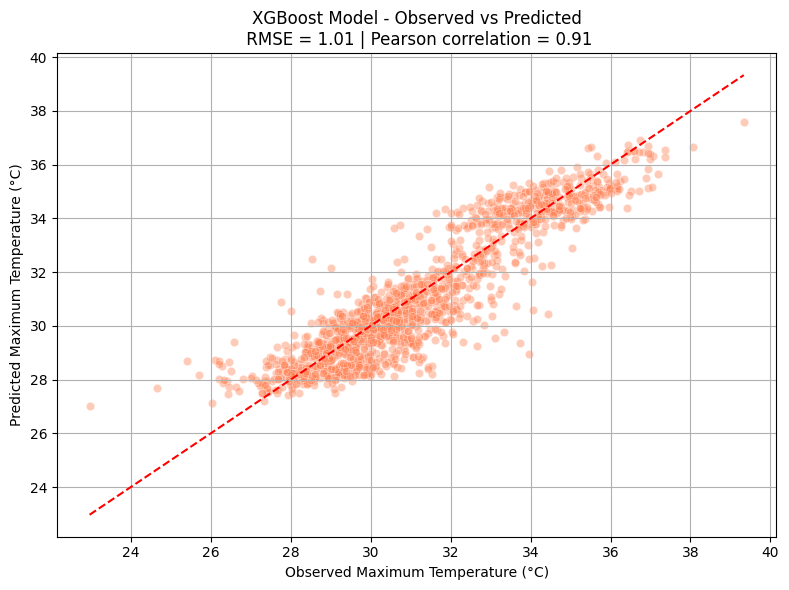

(np.float64(1.0058814303171577), np.float64(0.9141097827791356))

In [35]:
model = XGBRegressor(**study.best_params)
X = X.reindex(sorted(X.columns), axis=1)
model.fit(X, y,sample_weight=df['sample_weight'])

tmax_resul = df.copy()

tmax_resul['Tmax_pred'] = model.predict(X)



# Calcular métricas
rmse = np.sqrt(mean_squared_error(tmax_resul['Tmax'], tmax_resul['Tmax_pred']))
pearson_corr, _ = pearsonr(tmax_resul['Tmax'], tmax_resul['Tmax_pred'])

# Graficar observados vs estimados
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x='Tmax', y='Tmax_pred', data=tmax_resul, alpha=0.4,color="#FF7F50")
plt.plot([tmax_resul['Tmax'].min(), tmax_resul['Tmax'].max()], [tmax_resul['Tmax'].min(), tmax_resul['Tmax'].max()], 'r--')
plt.xlabel("Observed Maximum Temperature (°C)")
plt.ylabel("Predicted Maximum Temperature (°C)")
plt.title(f"XGBoost Model - Observed vs Predicted\n RMSE = {rmse:.2f} | Pearson correlation = {pearson_corr:.2f}")
plt.grid(True)
plt.tight_layout()
plt.show()

rmse, pearson_corr

## Resultados mejor modelo Xgboost

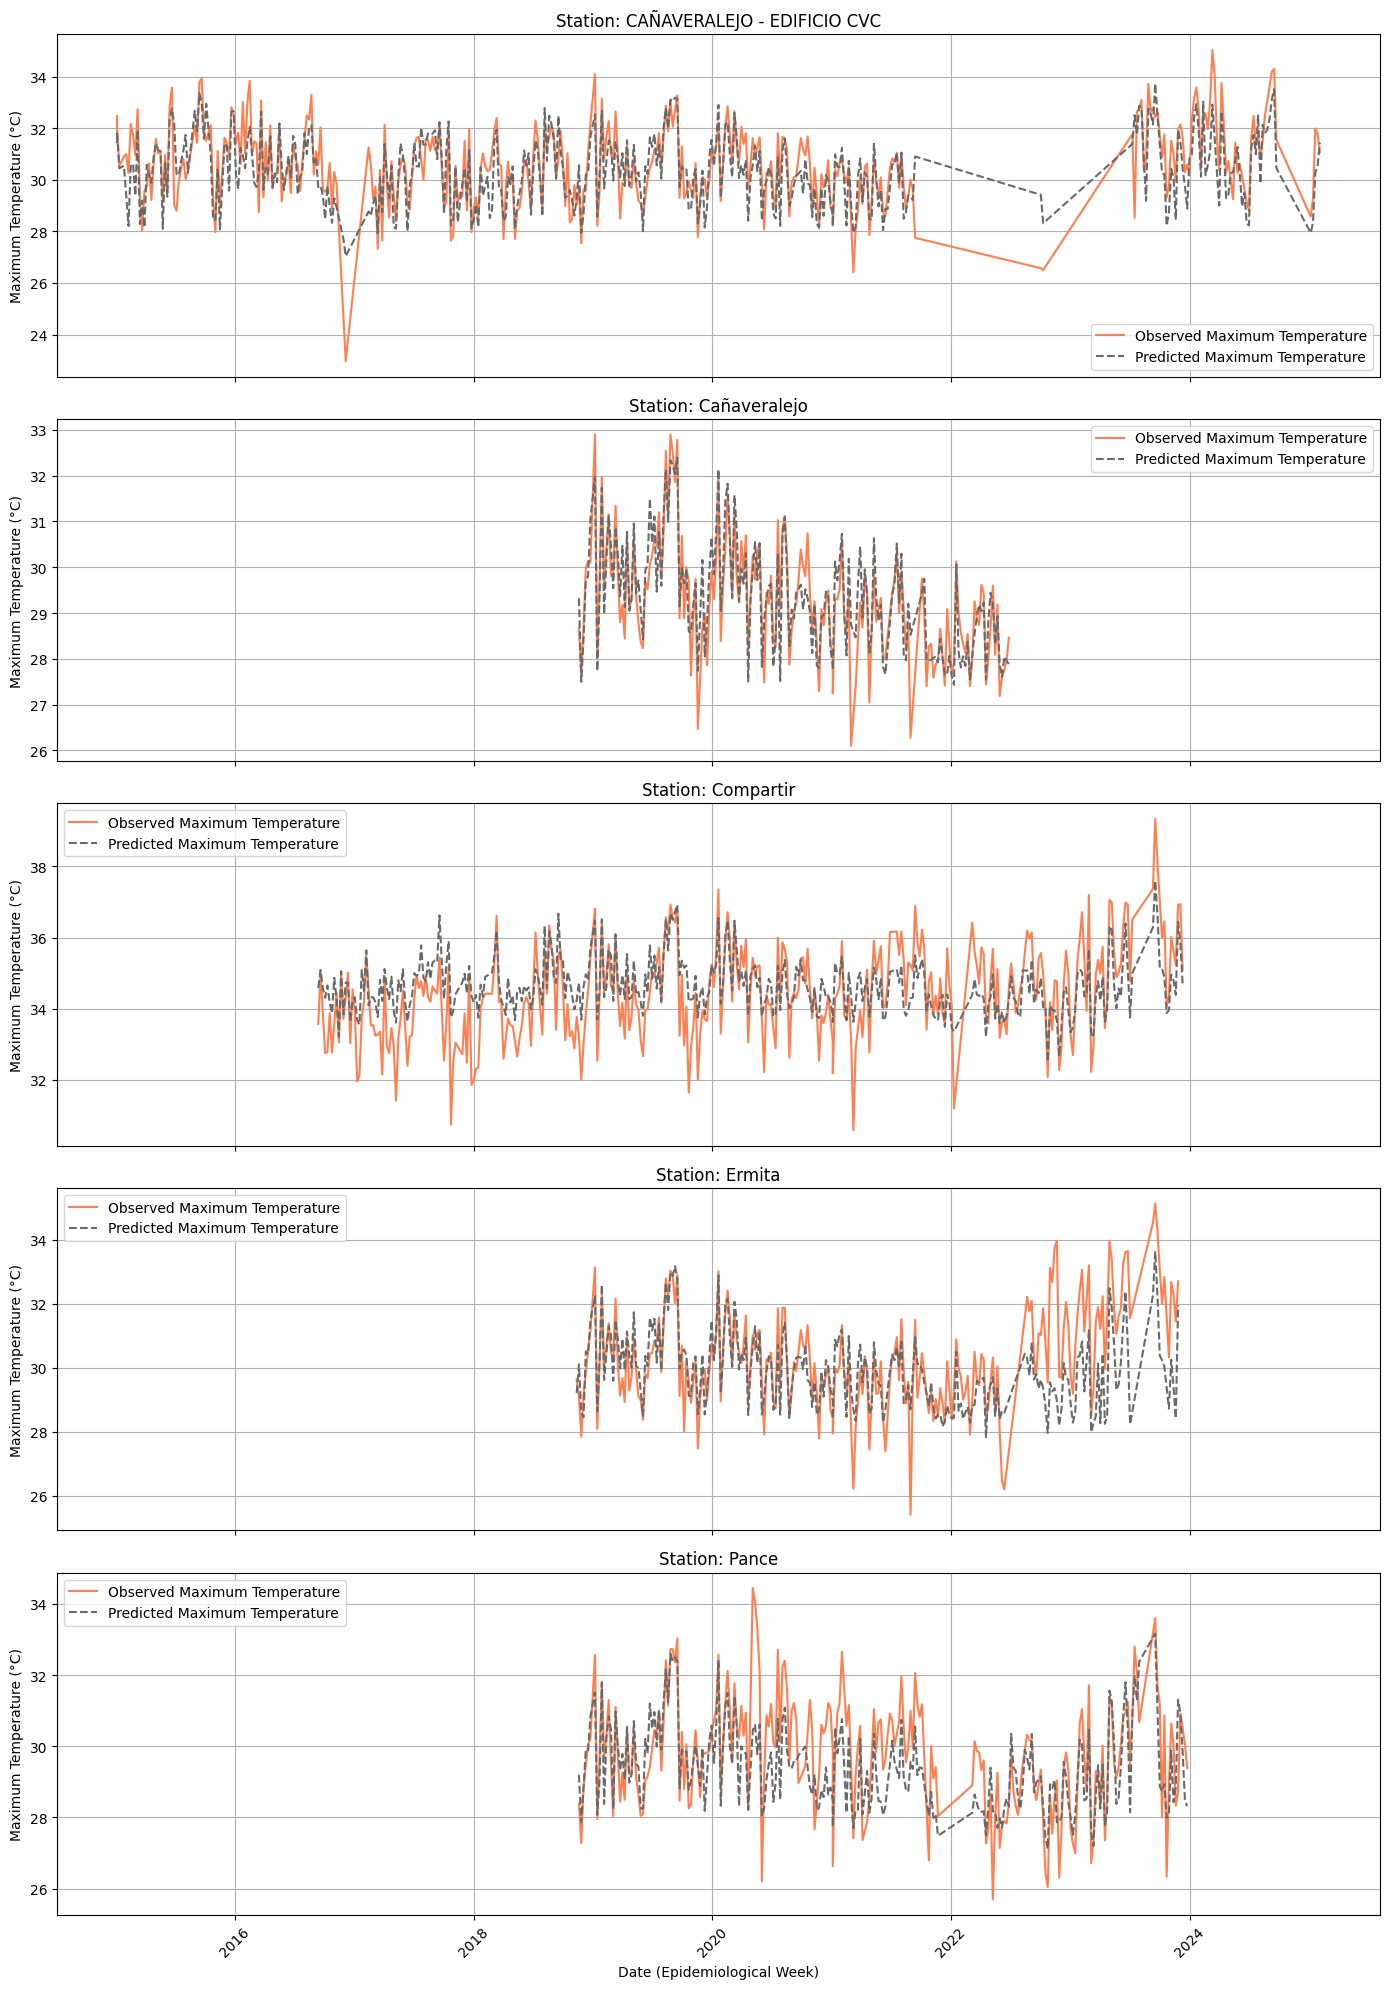

In [38]:
# Usar todos los datos disponibles para todas las estaciones (sin limitar a 50 por estación)
full_plot_data = tmax_resul.copy()
full_plot_data['Fecha'] = pd.to_datetime(full_plot_data['epi_week'] + '-1', format='%Y-%W-%w', errors='coerce')
full_plot_data = full_plot_data.dropna(subset=['Tmax', 'Tmax_pred', 'Fecha'])

# Obtener estaciones únicas
stations = full_plot_data['Estacion'].unique()

# Crear un gráfico por estación
fig, axes = plt.subplots(nrows=len(stations), ncols=1, figsize=(14, 4 * len(stations)), sharex=True)

# Asegurar que axes es iterable
if len(stations) == 1:
    axes = [axes]

# Generar los subgráficos
for ax, station in zip(axes, stations):
    data = full_plot_data[full_plot_data['Estacion'] == station]
    ax.plot(data['Fecha'], data['Tmax'], label='Observed Maximum Temperature', linestyle='-',color="#FF7F50")
    ax.plot(data['Fecha'], data['Tmax_pred'], label='Predicted Maximum Temperature', linestyle='--',color="#696969")
    ax.set_title(f'Station: {station}')
    ax.set_ylabel('Maximum Temperature (°C)')
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

plt.xlabel("Date (Epidemiological Week)")
plt.tight_layout()
plt.show()

## Shapply values Xgboost 

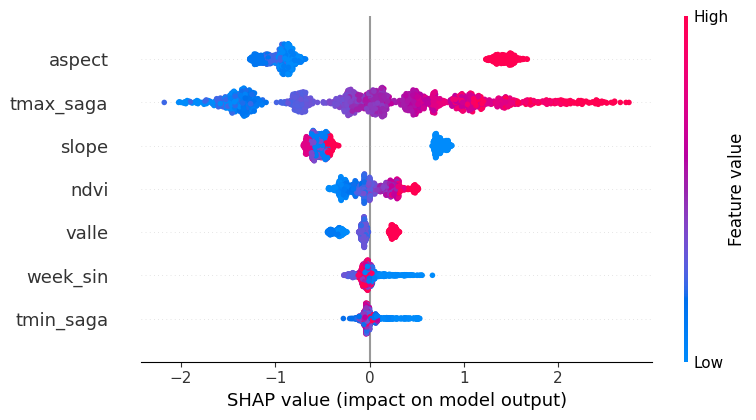

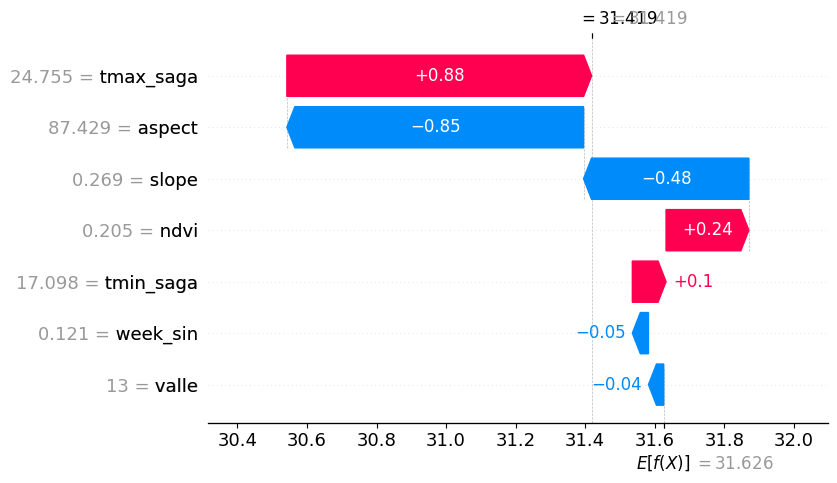

In [40]:
# Usar un subconjunto si hay muchos datos
X_sample = X  # opcional, para visualización más rápida

# Crear el objeto SHAP explainer
explainer = shap.Explainer(model)

# Calcular los valores SHAP
shap_values = explainer(X_sample)

# Visualización: resumen de importancia global
shap.summary_plot(shap_values, X_sample)

# Visualización: aportes en una predicción individual
shap.plots.waterfall(shap_values[0])

## Comparación linea base sesgo en media y varianza

In [41]:
assesment = tmax_resul[["Estacion","year","week","Tmax","tmax_saga","Tmax_pred"]]

# Calcular métricas
def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    corr, _ = pearsonr(y_true, y_pred)
    bias = np.mean(y_pred - y_true)
    var_ratio = np.var(y_pred) / np.var(y_true)
    return rmse, corr, bias, var_ratio


grouped_results = []

for station, group in assesment.groupby("Estacion"):
    metrics_saga = compute_metrics(group["Tmax"], group["tmax_saga"])
    metrics_xgb = compute_metrics(group["Tmax"], group["Tmax_pred"])
    improvement = [s - x for s, x in zip(metrics_saga, metrics_xgb)]
    
    for metric, saga_val, xgb_val, imp_val in zip(["RMSE", "Pearson r", "Bias (mean error)", "Variance Ratio"], metrics_saga, metrics_xgb, improvement):
        grouped_results.append({
            "Station": station,
            "Metric": metric,
            "SAGA_Lapserate": saga_val,
            "XGBoost": xgb_val,
            "Improvement": imp_val
        })

results_by_station_df = pd.DataFrame(grouped_results)

results_by_station_df

,Station,Metric,SAGA_Lapserate,XGBoost,Improvement
0,CAÑAVERALEJO - EDIFICIO CVC,RMSE,6.307733,0.967719,5.340014
1,CAÑAVERALEJO - EDIFICIO CVC,Pearson r,0.747779,0.793759,-0.045980
2,CAÑAVERALEJO - EDIFICIO CVC,Bias (mean error),-6.209244,-0.235684,-5.973561
3,CAÑAVERALEJO - EDIFICIO CVC,Variance Ratio,0.203913,0.777687,-0.573774
4,Cañaveralejo,RMSE,5.026037,0.630670,4.395368
5,Cañaveralejo,Pearson r,0.839064,0.870304,-0.031240
6,Cañaveralejo,Bias (mean error),-4.966304,0.077064,-5.043368
7,Cañaveralejo,Variance Ratio,0.302112,0.906543,-0.604431
8,Compartir,RMSE,9.436463,0.934430,8.502033
9,Compartir,Pearson r,0.607561,0.725582,-0.118021


In [ ]:
## Guarda el  mejor modelo para tmax

dump(model, "D:/OneDrive - CGIAR/Desktop/downscaling/models/xgb_tmax.joblib")


['D:/OneDrive - CGIAR/Desktop/downscaling/models/xgb_tmax.joblib']

: 